# Transfer Learning

It is the process of taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages the previous network's accuracy for a new task.

In [5]:
!pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@fork/keras2.2.4

  Cloning https://github.com/datumbox/keras (to revision fork/keras2.2.4) to /tmp/pip-req-build-4l_eelyz
  Running command git clone -q https://github.com/datumbox/keras /tmp/pip-req-build-4l_eelyz
  Running command git checkout -b fork/keras2.2.4 --track origin/fork/keras2.2.4
  Switched to a new branch 'fork/keras2.2.4'
  Branch 'fork/keras2.2.4' set up to track remote branch 'fork/keras2.2.4' from 'origin'.
  Stored in directory: /tmp/pip-ephem-wheel-cache-la91j_n1/wheels/a4/55/2c/4455b1e40b1f881fd5f544b8a166a4e63ce7691453c1d4ac0c
Successfully built Keras
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [0]:
  %matplotlib inline

  import os

  import random
  import numpy as np
  import keras

  import matplotlib.pyplot as plt
  from matplotlib.pyplot import imshow

  from keras.preprocessing import image
  from keras.applications.imagenet_utils import preprocess_input
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Flatten, Activation
  from keras.layers import Conv2D, MaxPooling2D
  from keras.models import Model

## Dataset

The [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset consists around 9000 images in 300 x 200 pixel dimensions, labelled under 101 categories.

In [7]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################## 100.0%
101_ObjectCategories  sample_data


In order to keep the class distribution fairly balanced, images under 5 categories are excluded bringing the total number of images down to around 6000.



In [8]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/crayfish', '101_ObjectCategories/yin_yang', '101_ObjectCategories/lotus', '101_ObjectCategories/schooner', '101_ObjectCategories/cougar_face', '101_ObjectCategories/nautilus', '101_ObjectCategories/ewer', '101_ObjectCategories/emu', '101_ObjectCategories/cannon', '101_ObjectCategories/rhino', '101_ObjectCategories/wrench', '101_ObjectCategories/soccer_ball', '101_ObjectCategories/ant', '101_ObjectCategories/flamingo', '101_ObjectCategories/beaver', '101_ObjectCategories/saxophone', '101_ObjectCategories/wild_cat', '101_ObjectCategories/watch', '101_ObjectCategories/brontosaurus', '101_ObjectCategories/pyramid', '101_ObjectCategories/car_side', '101_ObjectCategories/bonsai', '101_ObjectCategories/gramophone', '101_ObjectCategories/headphone', '101_ObjectCategories/gerenuk', '101_ObjectCategories/crocodile_head', '101_ObjectCategories/dolphin', '101_ObjectCategories/stapler', '101_ObjectCategories/electric_guitar', '101_ObjectCategories/grand_piano', '101_ObjectCat

Use the helper function get_image(path) to load the images correctly into the array and resize them to 224 x 224 pixel dimensions, for the pretrained ResNet-50 model.

In [0]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Create numpy arrays x and y to store the images as an one-dimensional array and the labels as integers respectively.

In [0]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order to prevent any bias or pattern.

In [0]:
random.shuffle(data)

Create training (70%), validation (15%) and test (15%) sets out of *'data'*. 


In [0]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate the training, validation and test sets for labels.

In [13]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[51, 26, 80, 28, 29, 60, 70, 62, 63, 46, 76, 60, 62, 63, 61, 71, 5, 43, 79, 1, 58, 48, 69, 4, 40, 14, 36, 93, 72, 19, 14, 0, 21, 41, 55, 40, 21, 94, 20, 48, 17, 89, 82, 28, 1, 51, 23, 82, 20, 29, 50, 21, 85, 90, 92, 69, 55, 37, 82, 58, 35, 56, 21, 41, 29, 87, 85, 20, 41, 61, 55, 9, 21, 37, 49, 96, 17, 28, 82, 17, 76, 84, 82, 0, 93, 1, 75, 81, 72, 83, 51, 1, 34, 17, 7, 52, 44, 60, 7, 20, 74, 91, 74, 96, 94, 85, 64, 80, 17, 28, 48, 68, 93, 51, 51, 71, 22, 94, 93, 75, 1, 63, 76, 50, 55, 69, 5, 53, 20, 17, 74, 52, 55, 59, 29, 36, 81, 69, 82, 46, 86, 89, 8, 68, 76, 44, 26, 40, 83, 7, 5, 69, 40, 29, 80, 57, 27, 36, 75, 83, 42, 75, 51, 29, 20, 38, 94, 59, 57, 25, 82, 55, 73, 13, 36, 92, 6, 19, 74, 48, 28, 67, 4, 11, 20, 73, 70, 76, 57, 42, 11, 34, 43, 49, 39, 77, 49, 40, 29, 55, 47, 38, 51, 38, 42, 64, 15, 8, 19, 37, 8, 41, 17, 63, 87, 32, 0, 3, 82, 88, 91, 50, 78, 41, 57, 74, 24, 82, 45, 75, 13, 10, 60, 1, 76, 62, 64, 35, 54, 87, 61, 88, 94, 93, 42, 26, 38, 74, 0, 67, 16, 31, 64, 26, 86, 20,

* Pre-process the image data into float32 values and normalize them between 0 and 1 by dividing them with 255 (RGB).
* Perform 'binarization' to convert the labels to one-hot vectors for including them as a feature while training the model. 

In [14]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


The data is divided into three subsets -- a training set `train`, a validation set `val`, and a test set `test` to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

In [15]:
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Show random images of the [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset.

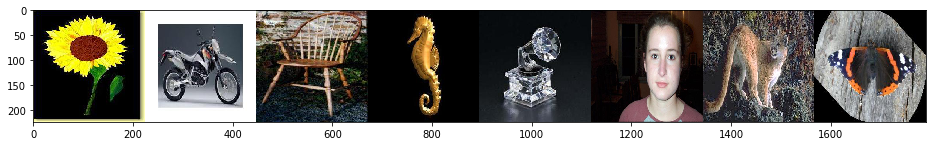

In [16]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Small CNN 1

Construct a neural network which contains 2 alternating convolutional and max-pooling layers, followed by a dropout after every other conv/pooling pair. After the last pooling layer, attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

In [17]:
modelCNN = Sequential()
print("Input dimensions: ",x_train.shape[1:])

modelCNN.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Conv2D(32, (3, 3)))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))

modelCNN.add(Dropout(0.25))

modelCNN.add(Flatten())
modelCNN.add(Dense(256))
modelCNN.add(Activation('relu'))

modelCNN.add(Dropout(0.5))

modelCNN.add(Dense(num_classes))
modelCNN.add(Activation('softmax'))

modelCNN.summary()

Input dimensions:  (224, 224, 3)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
______________________________________________________

Use categorical cross-entropy loss function and AdaDelta learning algorithm for compiling the model.

In [0]:
modelCNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Fit the model and train it for 10 epochs with a batch size of 128.

In [0]:
historyCNN = modelCNN.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

In [0]:
loss, accuracy = modelCNN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

## Small CNN 2

Construct another neural network which contains 2 alternating convolutional and max-pooling layers and after the last pooling layer, attach a fully-connected layer with 256 neurons, then finally a softmax classification layer for our classes.

Repeat the same procedure as the previous model - Small CNN 1

In [0]:
model2CNN = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model2CNN.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model2CNN.add(Activation('relu'))
model2CNN.add(MaxPooling2D(pool_size=(2, 2)))

model2CNN.add(Conv2D(32, (3, 3)))
model2CNN.add(Activation('relu'))
model2CNN.add(MaxPooling2D(pool_size=(2, 2)))

model2CNN.add(Flatten())
model2CNN.add(Dense(256))
model2CNN.add(Activation('relu'))

model2CNN.add(Dense(num_classes))
model2CNN.add(Activation('softmax'))

model2CNN.summary()

In [0]:
model2CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history2CNN = model2CNN.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

In [0]:
loss, accuracy = model2CNN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

## ResNet-50

ResNet-50 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 50 layers deep and can classify images into 1000 object categories, as a result of which the network has learned rich feature representations for a wide range of images. The network has an image input size requirement of 224-by-224 pixel dimensions.

Use this pre-trained network to train an image classifier on our dataset.


In [0]:
from keras.applications.resnet50 import ResNet50
from keras.utils.data_utils import get_file
model_resnet = ResNet50(weights='imagenet')
model_resnet.summary()

resnet_weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')

### ResNet-50 (Model 1)

In order to use this pre-trained network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of ResNet-50 from its input layer until the second to last layer, and then work with that, rather than modifying the ResNet-50 object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras Model class to initialize a new model whose input layer is the same as ResNet-50 but whose output layer is our new softmax layer, called new_classification_layer. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [0]:
# make a reference to ResNet-50's input layer
inp = model_resnet.input

#####################################################################################
# newRES = Sequential()

# # 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# # NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
# newRES.add(ResNet50(include_top = True, pooling = 'avg', weights = resnet_weights_path))
# newRES.add(Dense(num_classes, activation='softmax')
#            # make all layers untrainable by freezing weights (except for last layer)
# for l, layer in enumerate(newRES.layers[:-1]):
#     layer.trainable = False

# # ensure the last layer is trainable/not frozen
# for l, layer in enumerate(newRES.layers[-1:]):
#     layer.trainable = True
# newRES.summary()
##########################################################################################################
# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in ResNet-50, and make a reference to it
out = new_classification_layer(model_resnet.layers[-2].output)

# create a new network between inp and out
modelRES = Model(inp, out)


We are going to retrain this network, *modelRES* on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new layer at the end, with the expectation that the features that were learned in ResNet-50 should still be fairly relevant to the new image classification task.

By setting the trainable flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end.

So we go ahead and freeze the layers, and compile the new model with categorical cross-entropy loss function and AdaDelta learning algorithm.

In [0]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(modelRES.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(modelRES.layers[-1:]):
    layer.trainable = True

modelRES.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelRES.summary()

Looking at the summary, we see the network is identical to the ResNet-50 model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 97-neuron softmax.

As before, we go ahead and train the new model, using the same hyperparameters (batch size of 128 and 10 epochs) as before.

In [0]:
historyRES = modelRES.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

In [0]:
loss, accuracy = modelRES.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

### ResNet-50 (Model 2)

Apply the same procedure of ResNet-50 (Model 1) and train ResNet-50 (Model 2) with the only difference being unfreezing of one more extra layer.

In [0]:
model2RES = Model(inp, out)

In [0]:
# make all layers untrainable by freezing weights (except for last 2 layers)
for l, layer in enumerate(model2RES.layers[:-2]):
    layer.trainable = False

# ensure the last 2 layers are trainable/not frozen
for l, layer in enumerate(model2RES.layers[-2:]):
    layer.trainable = True

model2RES.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2RES.summary()

In [0]:
history2RES = model2RES.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

In [0]:
loss, accuracy = model2RES.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

## Data Augmentation

Augment the datasets by performing modifications such as rotating and flipping the images, and adjusting the input image float values (setting the mean to zero by feature, normalizing the standard deviation by feature and adjusting their ranges) to increase the size of the training and validation datasets, and create more tolerance for any distortions. 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [0]:
train_generator = datagen.flow(x_train, y_train, batch_size=128)

In [0]:
validation_generator = datagen.flow(x_val, y_val, batch_size=128)

### Data Augmentation of ResNet-50 (Model 1)

Fit the ResNet-50 (Model 1) to the augmented training and validation datasets.

In [0]:
historyRES_aug = modelRES.fit_generator(train_generator,
                                steps_per_epoch=len(x_train) / 128, 
                                epochs=10,
                                validation_data=validation_generator,
                                validation_steps=len(x_val) / 128)

### Data Augmentation of ResNet-50 (Model 2)

Fit the ResNet-50 (Model 2) to the augmented training and validation datasets.

In [0]:
history2RES_aug = model2RES.fit_generator(train_generator,
                                steps_per_epoch=len(x_train) / 128, 
                                epochs=10,
                                validation_data=validation_generator,
                                validation_steps=len(x_val) / 128)

## Comparison of Models

Compare the validation loss and validation accuracy of all the 6 models.

In [0]:
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121)
ax.plot(historyCNN.history["val_loss"], label='CNN 1 (with dropout layers)')
ax.plot(history2CNN.history["val_loss"], label='CNN 2 (without dropout layers)')
ax.plot(historyRES.history["val_loss"], label='ResNet-50 1 (except last layer)')
ax.plot(history2RES.history["val_loss"], label='ResNet-50 2 (except last 2 layers)')
ax.plot(historyRES_aug.history["val_loss"], label='ResNet-50 1 (except last layer & augmented)')
ax.plot(history2RES_aug.history["val_loss"], label='ResNet-50 2 (except last 2 layers & augmented)')
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.legend(loc='best')

ax2 = fig.add_subplot(122)
ax2.plot(historyCNN.history["val_acc"], label='CNN 1 (with dropout layers)')
ax2.plot(history2CNN.history["val_acc"], label='CNN 2 (without dropout layers)')
ax2.plot(historyRES.history["val_acc"], label='ResNet-50 1 (except last layer)')
ax2.plot(history2RES.history["val_acc"], label='ResNet-50 2 (except last 2 layers)')
ax2.plot(historyRES_aug.history["val_acc"], label='ResNet-50 1 (except last layer & augmented)')
ax2.plot(history2RES_aug.history["val_acc"], label='ResNet-50 2 (except last 2 layers & augmented)')
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.legend(loc='best')

plt.legend()
plt.show()

The validation accuracy of the CNN 1 model seems to be better across all models, especially against the CNN 2 model without dropout layers. The validation loss of both the CNN models is low when the number of epochs are less which might be due to the less number of layers.

The validation accuracy of the augmented ResNet-50 Model 1 is better than the unaugmented ResNet-50 Model 1. However, the validation accuracy of the unaugmented ResNet-50 Model 2 is better than augmented ResNet-50 Model 2.

It is suprising to see the small CNN models fare better than the pre-trained ResNet-50 models. It is even more puzzling to not see any pattern in the validation accuracies of ResNet-50 models when trained with augmented and unaugmented datasets. To speculate, this might due to distortions, over-fitting, under-fitting, the effect of hidden layers, etc. which requires further exploration of models.